In [9]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [10]:
# PREDIKSI LD GURU DAN CT SISWA

# Load data
df_guru = pd.read_csv("files/data_guru_klasifikasi.csv")
df_siswa = pd.read_csv("files/data_siswa_klasifikasi.csv")

# sekolah yg sama
def key_school(name):
    if pd.isna(name):
        return ""
    return " ".join(str(name).lower().strip().split()[:4])

df_guru["sekolah_key"] = df_guru["Asal Instansi"].apply(key_school)
df_siswa["sekolah_key"] = df_siswa["SekolahNama"].apply(key_school)

sekolah_sama = sorted(set(df_guru["sekolah_key"]) & set(df_siswa["sekolah_key"]))

# Rata-rata per Sekolah
df_guru_match = df_guru[df_guru["sekolah_key"].isin(sekolah_sama)]

ld_sekolah = (
    df_guru_match
    .groupby("sekolah_key")
    .agg(
        LD_Guru_Mean=("Mean_LD", "mean")
    )
    .round(3)
    .reset_index()
)

df_siswa_match = df_siswa[df_siswa["sekolah_key"].isin(sekolah_sama)]

ct_sekolah = (
    df_siswa_match
    .groupby("sekolah_key")
    .agg(
        CT_Siswa_Norm=("CT_norm", "mean")
    )
    .round(3)
    .reset_index()
)

df_regresi = pd.merge(
    ld_sekolah,
    ct_sekolah,
    on="sekolah_key",
    how="inner"
)

print("\nData untuk Prediksi LD Guru dan CT Siswa per Sekolah:")
df_regresi.round(3)




Data untuk Prediksi LD Guru dan CT Siswa per Sekolah:


,sekolah_key,LD_Guru_Mean,CT_Siswa_Norm
0,sd kristen banjarsari,3.535,0.355
1,sd kristen manahan surakarta,3.493,0.450
2,sd kristen setabelan 1,3.746,0.476
3,smk kristen 1 surakarta,3.363,0.228
4,smp kristen 1 surakarta,3.363,0.321


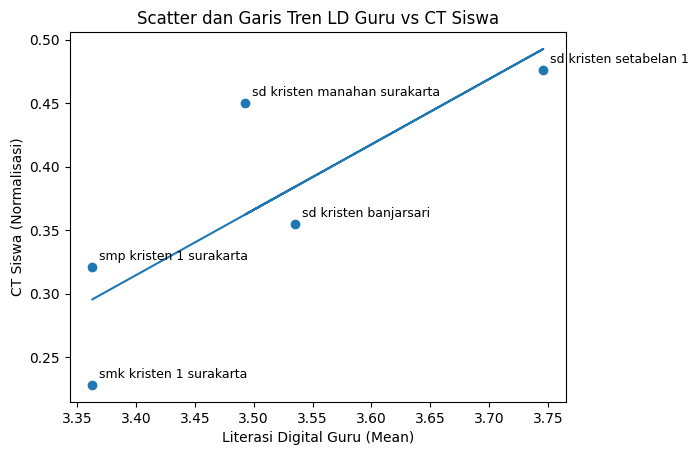

In [11]:
# regresi linear
x = df_regresi["LD_Guru_Mean"]
y = df_regresi["CT_Siswa_Norm"]
labels = df_regresi["sekolah_key"]  

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef)

plt.scatter(x, y)
plt.plot(x, poly1d_fn(x))

for i, label in enumerate(labels):
    plt.annotate(
        label,
        (x.iloc[i], y.iloc[i]),
        textcoords="offset points",
        xytext=(5,5),
        fontsize=9
    )

plt.xlabel("Literasi Digital Guru (Mean)")
plt.ylabel("CT Siswa (Normalisasi)")
plt.title("Scatter dan Garis Tren LD Guru vs CT Siswa")
plt.show()


In [12]:
# statistik regresi
X = df_regresi["LD_Guru_Mean"]
y = df_regresi["CT_Siswa_Norm"]

X = sm.add_constant(X) 
model = sm.OLS(y, X).fit()

model.summary()

c:\Users\HP\skripsi\s5_prediksi\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          CT_Siswa_Norm   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     5.647
Date:                Fri, 02 Jan 2026   Prob (F-statistic):             0.0979
Time:                        15:51:35   Log-Likelihood:                 7.6011
No. Observations:                   5   AIC:                            -11.20
Df Residuals:                       3   BIC:                            -11.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.4366      0.759     -1.892      0.155      -3.853       0.979
LD_Guru_Mean     0.5150      0.217      2.376      0.098      -0.175       1.205
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.551
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.373
Skew:                           0.477   Prob(JB):                        0.830
Kurtosis:                       2.062   Cond. No.                         94.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
# HASIL PREDIKSI REGRESI

df_output = df_regresi.copy()

# hitung CT prediksi
df_output["CT_Prediksi"] = (
    -1.4366 + 0.5150 * df_output["LD_Guru_Mean"]
)

df_output = df_output.rename(columns={
    "sekolah_key": "Sekolah",
    "LD_Guru_Mean": "LD_Mean",
    "CT_Siswa_Norm": "CT_Aktual"
})

df_output["Selisih"] = (
    df_output["CT_Aktual"] - df_output["CT_Prediksi"]
).round(3)

df_output[["LD_Mean", "CT_Aktual", "CT_Prediksi", "Selisih"]] = (
    df_output[["LD_Mean", "CT_Aktual", "CT_Prediksi", "Selisih"]].round(3)
)

df_output["Keterangan"] = df_output["Selisih"].apply(
    lambda x: "Lebih tinggi dari prediksi" if x > 0 else "Lebih rendah dari prediksi"
)

# pilih kolom akhir
df_output = df_output[
    ["Sekolah", "LD_Mean", "CT_Aktual", "CT_Prediksi", "Selisih", "Keterangan"]
]

print("\nHasil Prediksi CT Siswa berdasarkan LD Guru per Sekolah:")
df_output


Hasil Prediksi CT Siswa berdasarkan LD Guru per Sekolah:


,Sekolah,LD_Mean,CT_Aktual,CT_Prediksi,Selisih,Keterangan
0,sd kristen banjarsari,3.535,0.355,0.384,-0.029,Lebih rendah dari prediksi
1,sd kristen manahan surakarta,3.493,0.450,0.362,0.088,Lebih tinggi dari prediksi
2,sd kristen setabelan 1,3.746,0.476,0.493,-0.017,Lebih rendah dari prediksi
3,smk kristen 1 surakarta,3.363,0.228,0.295,-0.067,Lebih rendah dari prediksi
4,smp kristen 1 surakarta,3.363,0.321,0.295,0.026,Lebih tinggi dari prediksi


In [14]:
# HITUNG ERROR PREDIKSI
from sklearn.metrics import mean_squared_error, mean_absolute_error

# nilai aktual & prediksi
y_true = df_output["CT_Aktual"]
y_pred = df_output["CT_Prediksi"]

# hitung error
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE : {rmse:.3f}")
print(f"MAE  : {mae:.3f}")


RMSE : 0.053
MAE  : 0.045


In [15]:
summary_model = pd.DataFrame({
    "Metric": ["R²", "Adjusted R²", "RMSE", "MAE", "p-value slope"],
    "Value": [
        model.rsquared,
        model.rsquared_adj,
        rmse,
        mae,
        model.pvalues["LD_Guru_Mean"]
    ]
})

print("\nSummary Model Regresi:")
summary_model.round(3)



Summary Model Regresi:


,Metric,Value
0,R²,0.653
1,Adjusted R²,0.537
2,RMSE,0.053
3,MAE,0.045
4,p-value slope,0.098
